# text-to-speech synthesis demo

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

from synthesizer.inference import Synthesizer
# from dca_synthesizer.inference import Synthesizer
from IPython.display import Audio

import tensorflow as tf 
import numpy as np 
import librosa
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import itertools
import random 
import glob
from pathlib import Path
%matplotlib inline

/home/shiyao/anaconda3/envs/aishell3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shiyao/anaconda3/envs/aishell3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shiyao/anaconda3/envs/aishell3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shiyao/anaconda3/envs/aishell3/lib

# Section 1. load resources
## 1.1 load speaker embedding table

In [16]:
# # TRAINSET EMBEDDINGS
EMBASE = 'datasets/aishell3/val_embeddings'
AUDIOBASE = 'datasets/aishell3/audio'
embed_paths = glob.glob(os.path.join(EMBASE, '*'))

def any_embedding() : 
    """returns a random speaker embedding vector"""
    return np.load(
        random.sample(embed_paths, 1)[0]
    )

import re
emb_pattern = re.compile(r'embed-(?P<sid>[A-Z0-9]+)\.wav\.npy')

def any_embedding_with_spk() : 
    """returns a tuple of speaker embedding and its corresponding audio"""
    emb_path = random.sample(embed_paths, 1)[0]
    m = emb_pattern.match(os.path.basename(emb_path))
    a_path = f'audio-{m.group("sid")}.wav.npy'
    
    return np.load(emb_path), np.load(os.path.join(AUDIOBASE, a_path))

def any_embedding_from_spk(spk) : 
    """returns a tuple of speaker embedding and its corresponding audio sample for a given speaker"""
    paths = glob.glob(os.path.join(EMBASE, f'embed-{spk}*'))
    if len(paths) == 0 : 
        raise AssertionError()
    emb_path = random.sample(paths, 1)[0]
    m = emb_pattern.match(os.path.basename(emb_path))
    a_path = f'audio-{m.group("sid")}.wav.npy'
    
    return np.load(emb_path), np.load(os.path.join(AUDIOBASE, a_path))

## 1.2 load tacotron model

In [64]:
# ckpt_dir = os.path.join(
#     'tf_multispeaker',
#     'feedback_synthesizer',
#     'saved_models',
#     'logs-best_of_ssb_joint_vad_slow_half_l2_v2',
#     'taco_pretrained'
# )

ckpt_dir = os.path.join(
    'pretrained',
    'tacotron_ckpt'
)

Synthesizer.hparams.tacotron_num_gpus = 1
Synthesizer.hparams.tacotron_batch_size=1

synthesizer = Synthesizer(Path(ckpt_dir), low_mem=False)

Found synthesizer "pretrained" trained to step 1402500


In [4]:
# import melgan_archodd
# import torch

# melgan = melgan_archodd.MelVocoder('tf_multispeaker/melgan_archodd/logs/db1_db4_ljs_finetune')

# # mel2audio(mel-spectrogram : ndarray) -> ndarray
# # override this to replace vocoder
# def mel2audio(mel) : 
#     x_t = melgan.inverse(torch.from_numpy(mel)[None]).detach().cpu().numpy()
#     return x_t

In [36]:
from vocoder.inference import load_model, infer_waveform
wavrnn = load_model(os.path.join(
    'tf_multispeaker',
    'vocoder',
    'saved_models',
    'aishell',
    'aishell_ssb.pt'
))

def mel2audio(mel) : 
    return infer_waveform(mel)[None]


Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at tf_multispeaker/vocoder/saved_models/aishell/aishell_ssb.pt


In [5]:
def mel2audio(mel) : 
    return np.random.randn(14000)[None]

## 1.3 helper functions for synthesis

In [6]:
def write_waveform(wav, filename) : 
    librosa.output.write_wav(filename, wav, 16000)

def self_cor(mat) : 
    mode = np.sqrt(np.sum(mat**2, axis=0))[:, None]
    return mat.T @ mat / (mode.T * mode)

def align_measure(attn_mat) : 

    """
    measures an attention map's `correctness`;
    a large value means the attention scores are scattered and incorrect,
    while a small value indicates the alignment tends to form a diagonal-line.

    the measure is length-normalized, but the final silent segments could cause
    the result to raise, but because the model tends to synthesize a constant length
    silent ending segment, this effect could only result in a constant offset from zero
    when comparing among results that are about the same lengths (usually ~ 10)

    preliminary experiments shows : 
        10 usually means good;
        30 means the diagonal trends does exist, but about half of the attetion-map is scatterd
        60 or higher means completely lose focus
    """

    L = attn_mat.shape[0]
    Q = self_cor(attn_mat.T)
    return (np.trace(Q @ Q.T) - L) / L

In [27]:
# from cn_convert.phone_convert import transfer_line

def synth_only(txt, emb) : 
    texts = [txt]
#     texts = [transfer_line(txt).split('|')[0] for txt in [txt]]
    embed = emb[None]
    
    mel, align = synthesizer.synthesize_spectrograms(texts, embed, return_alignments=True)
    print(mel[0].shape)
    x_t = mel2audio(mel[0])
    
    print(x_t.shape)
    
    return x_t[0], align[0], mel[0]

def synth_and_display(txt, emb) : 

    x_t, align, mel = synth_only(txt, emb)
    print(x_t.shape)
    display(Audio(x_t, rate=16000))
    fig, axs = plt.subplots(1,3, figsize=(20,3))
    axs[0].matshow(mel, aspect='auto')
    axs[1].matshow(align, aspect='auto')
    axs[2].plot(x_t)
    
    return x_t, align, mel

# section 2. synthesis demo

In [28]:
# demo texts are an excerpt of training samples

texts = """
SSB00430444|持起红缨枪追赶对方半公里|CH IY2 Q IY3 HH UH2 NG2 Y IY1 NG1 Q IY1 AE1 NG1 JH UW1 IY1 G AE3 N3 D UW4 IY4 F AE1 NG1 B AE4 N4 G UH1 NG1 L IY3|SSB0043
SSB00180296|过把瘾的演员有什么|G UW4 AO4 B AA2 Y IY3 N3 D ER5 Y AE3 N3 Y UW2 AE2 N2 Y OW2 SH AH3 N3 M ER5|SSB0018
SSB00570415|放一首情歌|F AE4 NG4 Y IY4 SH OW3 Q IY2 NG2 G ER1|SSB0057
SSB00800019|校园青春校园小说有什么|X IY4 AW4 Y UW2 AE2 N2 Q IY1 NG1 CH UW1 AH1 N1 X IY4 AW4 Y UW2 AE2 N2 X IY3 AW3 SH UW1 AO1 Y OW2 SH AH3 N3 M ER5|SSB0080
SSB00570241|大智慧阿思达克通讯社|D AA4 JH IY4 HH UW4 IY4 AA1 S IY1 D AA2 K ER4 T UH1 NG1 X UW4 AH4 N4 SH ER4|SSB0057
SSB00330113|胡笳汉月|HH UW2 J IY1 AA1 HH AE4 N4 Y IY4 EH4|SSB0033
SSB00800207|别做你儿子的耻辱|B IY2 EH2 Z UW4 AO4 N IY3 AA2 R2 Z IY5 D ER5 CH IY2 R UW3|SSB0080
"""
texts = [(x[1],x[2]) for x in [s.split('|') for s in [s for s in texts.split('\n') if s != '']]]

synthesized texts : ('放一首情歌', 'F AE4 NG4 Y IY4 SH OW3 Q IY2 NG2 G ER1')
(80, 155)
{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 3.8kHz | }(1, 30800)
(30800,)


align score : 25.506019005408653


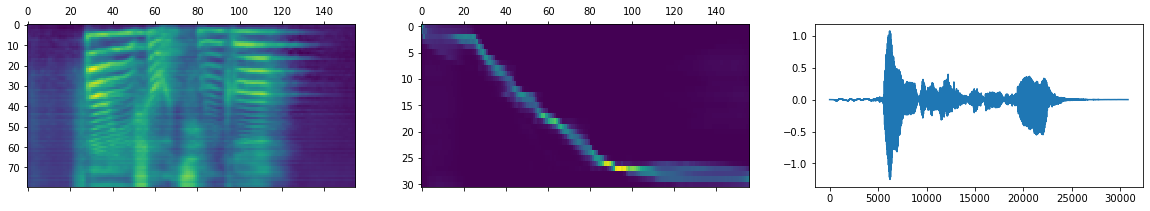

In [66]:
emb = any_embedding()   # random embedding
hans, short_txt = random.choice(texts)   # random texts
print(f'synthesized texts : {hans,short_txt}')
wav_t, align, _mel = synth_and_display(short_txt, emb)
print(f'align score : {align_measure(align.T)}')